* 화성시에서 제공한 "moc_link_2018.geojson" 파일은 수정해야 할 노드가 많았다.
* 따라서 가장 최신의 도로 네트워크 자료를 찾아서 최대한 수정을 적게 하는 방향으로 가려고 한다.

# 1. 표준 노드 링크 파일 가공

## 1. 데이터 다운로드

#### 1. ITF에 접속해서 전국 표준 노드 링크 파일을 다운받는다.  
다운받은 파일은 shp 형태이므로 geojson으로 변환해줄 필요가 있다.

<p>
<img src="post1/ITS 국가교통정보센터.png" width="400" height="100" align="center">
</p>

#### 2. 다운 받은 파일을 QGIS에 올린 후 geojson 파일로 변환한다.

<p>
<img src="post1/qgis에 shp 올리기.png" width="400" height="100" align="center">
</p>

## 2. 데이터 정제

In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
link_df = gpd.read_file('moct_link_2021.geojson')
node_df = gpd.read_file('moct_node_2021.geojson')

* 필요한 열만 가져온다.

In [3]:
link_df = link_df[['LINK_ID', 'F_NODE', 'T_NODE', 'LENGTH', 'geometry']]

* 전국의 노드이므로 화성시만 추출한다.
* 화성시는 id 앞에 233으로 시작한다.

In [4]:
link_df_new = link_df[link_df['LINK_ID'].str.startswith('233')].reset_index(drop = True)
node_df_new = node_df[node_df['NODE_ID'].str.startswith('233')][['NODE_ID', 'geometry']].reset_index(drop = True)
node_df_new.head(3)

,NODE_ID,geometry
0,2330015400,POINT (127.03028 37.20909)
1,2330020005,POINT (126.95123 37.22193)
2,2330020702,POINT (126.94803 37.22376)


* node_df_new의 geometry는 (경,위도) 점으로 이루어져 있다. 경도, 위도만 따로 추출하자.

In [5]:
lon = []
lat = []
for rows in range(len(node_df_new)) :
    lon.append(list(node_df_new['geometry'][rows].coords[0])[0])
    lat.append(list(node_df_new['geometry'][rows].coords[0])[1])
    
node_df_new['lon'] = lon
node_df_new['lat'] = lat

node_df_new.head(3)

,NODE_ID,geometry,lon,lat
0,2330015400,POINT (127.03028 37.20909),127.030284,37.209088
1,2330020005,POINT (126.95123 37.22193),126.951226,37.221933
2,2330020702,POINT (126.94803 37.22376),126.948026,37.223757


In [6]:
merge_df = pd.merge(link_df_new, node_df_new, left_on = 'F_NODE', right_on = 'NODE_ID').drop(['NODE_ID', 'geometry_y'], axis = 1)
merge_df.head(3)

,LINK_ID,F_NODE,T_NODE,LENGTH,geometry_x,lon,lat
0,2334338501,2330512701,2330515401,213.408206,"MULTILINESTRING ((127.02704 37.20789, 127.0280...",127.027126,37.207922
1,2334328201,2330512701,2330014302,298.564290,"MULTILINESTRING ((127.02710 37.20797, 127.0248...",127.027126,37.207922
2,2334328301,2330512701,2330015200,102.049639,"MULTILINESTRING ((127.02715 37.20787, 127.0281...",127.027126,37.207922


In [7]:
real_merge = pd.merge(merge_df, node_df_new, left_on='T_NODE', right_on='NODE_ID', 
                      suffixes=('_f', '_t')).drop(['NODE_ID', 'geometry'], axis = 1)
print(real_merge.shape)
real_merge.head(3)

(11071, 9)


,LINK_ID,F_NODE,T_NODE,LENGTH,geometry_x,lon_f,lat_f,lon_t,lat_t
0,2334338501,2330512701,2330515401,213.408206,"MULTILINESTRING ((127.02704 37.20789, 127.0280...",127.027126,37.207922,127.028098,37.206159
1,2334337201,2330515101,2330515401,187.255507,"MULTILINESTRING ((127.02903 37.20464, 127.0281...",127.028958,37.204614,127.028098,37.206159
2,2334338401,2330515801,2330515401,66.966409,"MULTILINESTRING ((127.02876 37.20647, 127.0280...",127.028790,37.206410,127.028098,37.206159


In [8]:
real_merge.rename(columns = {'geometry_x' : 'geometry'}, inplace = True)

* 'geometry'를 리스트형태로 바꿔줘야 시각화가 가능므로 바꾼다.

In [9]:
ret = []
geo = real_merge['geometry']
for x in geo:
    first = []
    for j in range(len(x[0].coords)) :
            first.append(list(list(x[0].coords)[j]))
            
    ret.append(first)

real_merge['geo'] = ret

## 3. 시각화

In [10]:
import osmnx as ox
import networkx as nx

import pydeck as pdk

In [11]:
layer_line = pdk.Layer(
    'PathLayer',
    real_merge,
    get_path='geo',
    get_width= 2,
    get_color='[255, 221, 0]',
    pickable=True,
    auto_highlight=True
)

layer_f_node = pdk.Layer(
    'ScatterplotLayer',
    real_merge,
    get_position='[lon_f, lat_f]',
    get_radius= 5,
    get_color='[255, 221, 0]',
    pickable=True,
    auto_highlight=True
)

layer_t_node = pdk.Layer(
    'ScatterplotLayer',
    real_merge,
    get_position='[lon_t, lat_t]',
    get_radius= 5,
    get_color='[255, 221, 220]',
    pickable=True,
    auto_highlight=True
)

center = [126.908, 37.132]
view_state = pdk.ViewState(
    longitude=center[0],
    latitude=center[1],
    zoom=10)

r = pdk.Deck(layers=[layer_line, layer_f_node, layer_t_node], initial_view_state=view_state, 
             mapbox_key = 'pk.eyJ1Ijoid293bmRkbDE2IiwiYSI6ImNrdHA1YXlvODBqODkyeG8zcHV3bTV3b2QifQ.uEqIwnfKUDUHuiH5epXfog')
# r.to_html('layer_line.html')

* geojson파일로 만들려면 리스트형이 없어야 하므로 드랍시킨다.

In [12]:
real_merge.drop('geo', inplace = True, axis = 1)

In [13]:
real_merge.to_file('moc_2021.geojson', driver="GeoJSON")  

## 4. Multilinestring의 위/경도를 분리하기

* Multilinestring을 보면 여러 개의 점으로 이어진 선이라는 것을 알 수 있다. Multilinestring을 점들로 분리하자.

<p>
<img src="post1/multilinestring to dot.png" width="500" height="300" align="center">
</p>

In [14]:
from geopy import distance
from tqdm import tqdm

In [15]:
df_link = gpd.read_file('moc_2021.geojson')
df_link.head(2)

,LINK_ID,F_NODE,T_NODE,LENGTH,lon_f,lat_f,lon_t,lat_t,geometry
0,2334338501,2330512701,2330515401,213.408206,127.027126,37.207922,127.028098,37.206159,"MULTILINESTRING ((127.02704 37.20789, 127.0280..."
1,2334337201,2330515101,2330515401,187.255507,127.028958,37.204614,127.028098,37.206159,"MULTILINESTRING ((127.02903 37.20464, 127.0281..."


In [16]:
new_rows = []
id = 0
for row in tqdm(df_link.itertuples(), total=len(df_link)):

    # 시작/끝 노드 저장
    f_node = getattr(row, 'F_NODE')
    t_node = getattr(row, 'T_NODE')
    m_line_string = getattr(row, 'geometry')

    # MultiLineString 을 2차원 [[lon, lat], [lon, lat] ...] 형태로 바꿔 coords 에 저장(이렇게 하면 코드 줄일 수 있음)
    coords = np.array([])
    for line_string in m_line_string:
        coords = np.append(coords, list(line_string.coords))
    coords = coords.reshape(-1, 2)

    # coords 에 있는 좌표 정보를 하나씩 읽어서 노드와 거리를 new_rows 에 저장
    for i in range(len(coords)-1):
        new_row = pd.Series()
        new_row['f_node_lon'] = coords[i][0]
        new_row['f_node_lat'] = coords[i][1]
        new_row['t_node_lon'] = coords[i+1][0]
        new_row['t_node_lat'] = coords[i+1][1]

        new_row['DIST'] = distance.distance(
            (new_row['f_node_lat'], new_row['f_node_lon']),
            (new_row['t_node_lat'], new_row['t_node_lon'])
        ).meters

        if i == 0:
            new_row['f_node'] = f_node
        else:
            new_row['f_node'] = new_rows[-1]['t_node']

        new_row['t_node'] = "{}-{}-{}-{}".format(f_node, t_node, i+1, id)
        new_rows.append(new_row)

    new_rows[-1]['t_node'] = t_node
    id += 1



100%|██████████| 11071/11071 [13:46<00:00, 13.39it/s] 


In [17]:
# 위에서 만든 new_rows 를 모두 합쳐서 데이터프레임 형태로 만듦
df_link_extend = pd.concat(new_rows, axis=1).T

df_link_extend['DIST'] = df_link_extend['DIST'].astype('int')
df_link_extend = df_link_extend.dropna()

# 작업한 내용을 피클라이저해서 저장공간 줄임
df_link_extend.to_pickle('df_link_extend.pkl')

print('df_link :', len(df_link))
print('df_link_extend :', len(df_link_extend))

df_link : 11071
df_link_extend : 105950


# 2. 저장한 피클 파일을 네트워크로 구성하고 굴곡도 구하기

### 1. 네트워크 구성하기

* 앞서 구한 f_node, t_node 데이터를 지도에 네트워크화해서 확인해본다.

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import geopandas as gpd

import pickle
from tqdm import tqdm

import osmnx as ox
import networkx as nx
import deckgljupyter.Layer as deckgl
import matplotlib.pyplot as plt

from geopy.distance import distance
import geopy.distance

with open('df_link_extend.pkl', 'rb') as f:
    node_extended = pickle.load(f)

node_extended.head()

,f_node_lon,f_node_lat,t_node_lon,t_node_lat,DIST,f_node,t_node
0,127.027,37.2079,127.028,37.2061,213,2330512701,2330515401
1,127.029,37.2046,127.028,37.2062,187,2330515101,2330515401
2,127.029,37.2065,127.028,37.2062,66,2330515801,2330515401
3,127.027,37.208,127.025,37.2071,222,2330512701,2330512701-2330014302-1-3
4,127.025,37.2071,127.025,37.207,15,2330512701-2330014302-1-3,2330512701-2330014302-2-3


In [2]:
# f_node, t_node(둘을 합쳐서 edge라고 함)로 그래프 만들기
make_graph = nx.from_pandas_edgelist(node_extended, 
                                     source='f_node', target='t_node',
                                     edge_attr='DIST', 
#                                      create_using = nx.MultiDiGraph,
                                    )

# f_node, t_node에 (경도, 위도) 정보 넣어줌
d = {}
for row in node_extended.itertuples():

    f_node_lon = getattr(row, 'f_node_lon')
    f_node_lat = getattr(row, 'f_node_lat')
    f_node =  getattr(row, 'f_node')
    t_node_lon = getattr(row, 't_node_lon')
    t_node_lat = getattr(row, 't_node_lat')
    t_node =  getattr(row, 't_node')

    d[t_node] = dict(x=t_node_lon, y=t_node_lat)
    d[f_node] = dict(x=f_node_lon, y=f_node_lat)

nx.set_node_attributes(make_graph, d)

In [3]:
access_token = 'pk.eyJ1Ijoid293bmRkbDE2IiwiYSI6ImNrdHA1YXlvODBqODkyeG8zcHV3bTV3b2QifQ.uEqIwnfKUDUHuiH5epXfog'
view_options = {
    'center': [126.908, 37.132],
    'zoom': 11,
    'style': 'mapbox://styles/mapbox/dark-v9',
    'access_token': access_token
}

In [4]:
def draw_graph(graph):
    # node 리스트 만들기 (node의 형태는 '233029221', '2342231435'처럼 점 하나하나가 따로 표현되어 있는 형태이다.)
    node_list = []
    for node in graph.nodes:
        node_list.append({
            'node': node,
            'position': list(graph.nodes[node].values())
        })

    # edge 리스트 만들기 (edge의 형태는 ('233432452', '23434254454')와 같이 하나로 묶여있는 형태이다.)
    link_list = []
    for edge in graph.edges:
        u, v = edge[0], edge[1]
        # pydeck에서는 이렇게 할 필요 없지만, deckgljupyter에서는 이렇게 끝과 끝 엣지를 
        # 딕셔너리로 연결해서 path를 만들어줘야 한다.
        link_list.append({
            'edge': "{} -> {}".format(u, v),
            'path': [list(graph.nodes[u].values()), list(graph.nodes[v].values())]
        })

    # draw map
    m = deckgl.Map(**view_options)

    m.add(deckgl.ScatterplotLayer(node_list,
                               getRadius=3,
                               getFillColor=[225, 120, 0],
                               pickable=True,
                               tooltip=['node']))

    m.add(deckgl.PathLayer(link_list,
                           getWidth=3,
                           getColor=[255, 221, 0],
                           opacity=0.5,
                           pickable=True,
                           tooltip=['edge']))

    m.show()

In [ ]:
draw_graph(make_graph)

<p>
<img src="post1/node_network.png" width="100%" align="center">
</p>

### 2. 굴곡도 구하기

#### 2-1. 버스 노선 데이터 확인 및 데이터 정제

In [6]:
routeinfo_start_end = pd.read_csv('route_start_end.csv', encoding = 'cp949')
print(routeinfo_start_end.shape)
print('pr_station_id 개수 : ', len(routeinfo_start_end['pr_station_id'].unique()))
routeinfo_start_end.head(3)

(12019, 15)
pr_station_id 개수 :  236


,seq,pr_station_id,bus_line_no,bus_line_no_seq,station_nm,station_id,mobile_no,중앙차로여부,관할관청,WGS84위도,WGS84경도,이비카드정류장ID,기종점여부,상하행여부,버스유형
0,68782,228000204,24,1,용인터미널,228001552,47634.0,노변정류장,경기도 용인시,37.232783,127.210100,9176783 4176783,기점,상행,일반
1,68783,228000204,24,2,송담대사거리(경유),277102467,NaN,NaN,NaN,37.233050,127.213433,7102467,-,상행,일반
2,68784,228000204,24,3,라이프아파트,228000664,29457.0,노변정류장,경기도 용인시,37.231483,127.213767,4150529,-,상행,일반


In [7]:
routeinfo = pd.read_csv('routestationinfo.csv', encoding = 'cp949')
print(routeinfo.shape)
routeinfo.head(3)

changable_df = routeinfo[['pr_station_id', 'bus_line_no']].drop_duplicates(keep = 'first').reset_index(drop = True)
changable_df.head(3)

route_start_end = pd.merge(routeinfo_start_end, changable_df, on = 'pr_station_id', how = 'left')
route_start_end.drop('bus_line_no_x', axis = 1, inplace = True)
route_start_end.rename(columns = {'bus_line_no_y' : 'bus_line_no'}, inplace = True)
route_start_end.head(3)

(37831, 7)


,seq,pr_station_id,bus_line_no_seq,station_nm,station_id,mobile_no,중앙차로여부,관할관청,WGS84위도,WGS84경도,이비카드정류장ID,기종점여부,상하행여부,버스유형,bus_line_no
0,68782,228000204,1,용인터미널,228001552,47634.0,노변정류장,경기도 용인시,37.232783,127.210100,9176783 4176783,기점,상행,일반,24
1,68783,228000204,2,송담대사거리(경유),277102467,NaN,NaN,NaN,37.233050,127.213433,7102467,-,상행,일반,24
2,68784,228000204,3,라이프아파트,228000664,29457.0,노변정류장,경기도 용인시,37.231483,127.213767,4150529,-,상행,일반,24


In [8]:
# 위도, 경도가 없으면 지도에 표시할 수 없으므로 null값이 있는 행은 삭제
aa = list(route_start_end[['WGS84위도', 'WGS84경도']][route_start_end[['WGS84위도', 'WGS84경도']].isna().any(axis = 1)].index)
print('위/경도 na값 :', len(aa))
route_start_end.drop(aa, inplace = True)
route_start_end.reset_index(inplace = True, drop = True)

위/경도 na값 : 0


In [9]:
print(route_start_end.shape)
print('pr_station_id 의 개수 :',len(route_start_end['pr_station_id'].unique()))

(12019, 15)
pr_station_id 의 개수 : 236


#### 2-3. 버스 노선별 최단거리 계산하기

In [10]:
# 화성시 폴리곤 데이터
df_sig = gpd.read_file('hwasung.geojson')
target_polygon = df_sig['geometry'].iloc[0]
polygons = list(target_polygon)[45]

In [11]:
# 아주 중요하다. 우리가 nx.from_pandas_edgelist로 만든 데이터는 graph라는 key가 없다. 
# graph에는 src가 들어있는데, 이게 있어야 ox.get_nearest_node를 사용할 수 있다.

make_graph.graph = {'created_date': '2021-10-06 21:39:29',
 'created_with': 'OSMnx 1.1.1',
 'crs': 'epsg:4326',
 'simplified': True}

In [12]:
# 그래프, 노드 번호를 입력하면 위/경도 반환
def get_xy_from_node(node_no):
    return make_graph.nodes[node_no]['x'], make_graph.nodes[node_no]['y']

In [13]:
# 노선별 최단거리 계산

shortest_routes = {}
no_lines = []
pr_station_id_lst = []

# 각 노선별로 하나씩 접근
for pr_station_id, gdf in tqdm(route_start_end.groupby(['pr_station_id'])):
    pr_station_id_lst.append(pr_station_id)
    # 1. 하나의 노선을 가지고 옴
    # 2. 정류장을 순서대로 정렬
    gdf = gdf.sort_values('bus_line_no_seq')
    gdf = gdf.reset_index(drop=True)
    
    # 3. 상행의 기/종점 표시
    up_start_idx = gdf[gdf['기종점여부'] == '기점'].index[0]
    
    if len(gdf[gdf['기종점여부'] == '회차']) == 0:
        if len(gdf[gdf['기종점여부'] == '종점']) == 0 :
            up_end_idx = gdf.iloc[-1:].index[0]
        else :
            up_end_idx = gdf[gdf['기종점여부'] == '종점'].index[0]  
    else :
        up_end_idx = gdf[gdf['기종점여부'] == '회차'].index[0]
    
    up_path = gdf.iloc[up_start_idx:up_end_idx]

    # 4. 노선에 존재하는 정류장이 1개뿐이면 해당 노선은 거리를 잴 수 없으므로 제외(잘못 수집된 경우를 생각해서)
    if len(up_path) <= 1:
        continue

    # 5. 시작과 끝의 transformed 한 좌표를 따로 추출
    start_latlng = up_path.iloc[0][['WGS84위도','WGS84경도']].values
    end_latlng = up_path.iloc[-1][['WGS84위도','WGS84경도']].values

    # 6. 추출한 좌표로 도로 네트워크 상에 존재하는 노드와 일치시킴(get_nearest_node)
    # 아래의 코드는 버스절류장의 위치 노드와 앞서 구성한 네트워크에 존재하는 노드를 거리를 재어서 가까운 곳에 위치시키는 과정
    start_node, s_dist = ox.get_nearest_node(make_graph, start_latlng, method='haversine', return_dist=True)
    end_node, e_dist = ox.get_nearest_node(make_graph, end_latlng, method='haversine', return_dist=True)
    
    # 7. 시작점 -> 종점간의 가장 짧은 경로 찾기(shortest_path)
    try:
        path_nodes = nx.shortest_path(make_graph, start_node, end_node, weight='distance')
        path = [list(get_xy_from_node(node)) for node in path_nodes]
        
    except:
        no_lines.append(pr_station_id)
        continue
    
    # path_length를 구하는 함수가 있긴 한데 제대로 작동하지 않아 이렇게 직접 코딩
    path_length = 0
    for i in range(len(path)) :
        if i == len(path)-1 :
            continue
        s = (path[i][1], path[i][0])
        e = (path[i+1][1], path[i+1][0])
        dist = geopy.distance.geodesic(s, e).m
        path_length += dist    
        
        
    # 8.계산한 정보들을 딕셔너리에 저장
    shortest_routes[pr_station_id] = {
        "name": gdf['station_nm'].iloc[0],
        "pr_station_id": pr_station_id,
        "path_length": path_length,
        "path": path
    }

100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [07:19<00:00,  1.86s/it]


In [14]:
with open('shortest_routes.pickle', 'wb') as f:
    pickle.dump(shortest_routes, f)

In [15]:
with open('shortest_routes.pickle', 'rb') as f:
    shortest_routes = pickle.load(f)

In [16]:
# 위에서 담은 path를 list로 넣어야 시각화 가능하므로 path는 list 형태로 만들어줘야 함
data = []
for route_id, values in shortest_routes.items():
    data.append(values['path'])

##### 시각화

In [17]:
# 노선별 색상 다르게 하기 위한 함수
def get_random_color(opacity=1):
    rgba = np.random.choice(range(256), size=3).tolist()
    rgba.append(opacity*255)
    return rgba

# 노선 그리기 위한 함수
def draw_path(path_list, stations=[], region=False, colors=[]): 

    # 시각화할 데이터 형태로 가공
    data = []
    for i, path in enumerate(path_list):
        data.append({
            'path': path,
            'color': get_random_color() if len(colors) == 0 else colors[i]
        })

    # 지도 설정
    v = view_options.copy()

    # 지도그리기
    m = deckgl.Map(**v)

    # path 그리기
    m.add(deckgl.PathLayer(data,
                           getWidth=30,
                           getColor='obj => obj.color'
                          ))

    # 화성시 폴리곤 그리기
    if region:
        x, y = polygons.exterior.xy
        data_region = [{
            "polygon": [[lon, lat] for lon, lat in zip(x, y)],
        }]
        m.add(deckgl.PolygonLayer(data_region, getFillColor=[255, 255, 255, 60]))
    m.show()

#### 2-4. 노선별 실제 운행거리 구하기

In [18]:
driving_routes = {}
rounding_routes = {}
excluded_routes = []
new_node_idx = 0
new_nodes = set()
err_dists = []
no_lines = []

# 각 노선별로 하나씩 접근
for pr_station_id, gdf in tqdm(route_start_end.groupby(['pr_station_id'])):
    # 1. 하나의 노선을 가지고 옴
    # 2. 정류장을 순서대로 정렬
    gdf = gdf.sort_values('bus_line_no_seq')
    gdf = gdf.reset_index(drop=True)
    
    # 3. 상행의 기/종점 표시
    up_start_idx = gdf[gdf['기종점여부'] == '기점'].index[0]
    
    if len(gdf[gdf['기종점여부'] == '회차']) == 0:
        if len(gdf[gdf['기종점여부'] == '종점']) == 0 :
            up_end_idx = gdf.iloc[-1:].index[0]
        else :
            up_end_idx = gdf[gdf['기종점여부'] == '종점'].index[0]  
    else :
        up_end_idx = gdf[gdf['기종점여부'] == '회차'].index[0]
    
    up_path = gdf.iloc[up_start_idx:up_end_idx]

    
    # 4. 노선에 존재하는 정류장이 1개뿐이면 해당 노선은 거리를 잴 수 없으므로 제외(잘못 수집된 경우를 생각해서)
    if len(up_path) <= 1:
        excluded_routes.append(pr_station_id)
        continue

    # 5. 정류장 하나하나의 위경도를 가져옴
    coords = up_path[['WGS84위도','WGS84경도']].values.tolist()
    prev_node = ox.get_nearest_node(make_graph, coords[0], method='haversine')
    path_list = np.array([get_xy_from_node(prev_node)])
    path_length = 0
    
    # 6. 현재 노선의 모든 정류장을 탐색
    for coord in coords[1:]:
        # 현재 정류장과 도로네트워크 위의 노드와의 거리를 잼
        # 가장 가까운 도로네트워크 위의 노드를 가져옴(시각화와 거리 계산을 위해)
        node, err_dist = ox.get_nearest_node(make_graph, coord, method='haversine', return_dist=True)
        err_dists.append(err_dist)
        
        # 만약 찾은 노드와 실제 정류장간의 거리 오차가 50m 를 넘는 경우 잘못된 노드를 찾았을 가능성이 높음
        # 따라서 해당 정류장 위치에 새 노드를 만들어 도로 네트워크에 연결
        if err_dist > 50:
            node = 'new_node_{}'.format(new_node_idx)
            _ = make_graph.add_node(node, x=coord[1], y=coord[0])
            prev_node_coord = (make_graph.nodes[prev_node]['y'], make_graph.nodes[prev_node]['x'])
            _ = make_graph.add_edge(prev_node, node, DIST = distance(coord, prev_node_coord).meters)
            _ = new_nodes.add(node)
            new_node_idx += 1
        elif prev_node in new_nodes:
            _ = make_graph.add_edge(prev_node, node, DIST = distance(coord, prev_node_coord).meters)

        # 도로 네트워크에서 현재 노드와 이전 노드간의 최단거리와 그 거리를 찾음
        try:
            path_nodes = nx.shortest_path(make_graph, prev_node, node, weight='distance')
            path = [list(get_xy_from_node(node)) for node in path_nodes]
            path_list = np.append(path_list, path)
            prev_node = node
            
            # 마찬가지로 거리구하는 함수가 있으나 제대로 작동하지 않아 직접 코드 짬
            for i in range(len(path)) :
                if i == len(path)-1 :
                    continue
                s = (path[i][1], path[i][0])
                e = (path[i+1][1], path[i+1][0])
                dist = geopy.distance.geodesic(s, e).m
                path_length += dist  
          
        except:
            no_lines.append(pr_station_id)
            continue

    # 7. 계산한 정보들을 딕셔너리에 저장
    driving_routes[pr_station_id] = {
        'name': gdf['bus_line_no'].iloc[0],
        'pr_station_id': pr_station_id,
        'path_length': path_length,
        'path': path_list.reshape(-1, 2).tolist(),
        'stations': up_path[['WGS84위도','WGS84경도']].values.tolist()
    }
        
print("{} of new nodes are created.".format(new_node_idx))    

100%|██████████████████████████████████████████████████████████████████████████████| 236/236 [1:15:35<00:00, 19.22s/it]

372 of new nodes are created.


In [19]:
##### 데이터 저장(1시간 36분이 걸려서 미리 구한 값을 저장해놓음)
with open('driving_routes.pickle', 'wb') as f:
    pickle.dump(driving_routes, f)
with open('excluded_routes.pickle', 'wb') as f:
    pickle.dump(excluded_routes, f) 
with open('new_node_id.pickle', 'wb') as f:
    pickle.dump(new_node_idx, f) 
with open('new_nodes.pickle', 'wb') as f:
    pickle.dump(new_nodes, f)
with open('err_dists.pickle', 'wb') as f:
    pickle.dump(err_dists, f)
with open('no_lines.pickle', 'wb') as f:
    pickle.dump(no_lines, f)    


In [20]:
##### 데이터 불러오기
with open('driving_routes.pickle', 'rb') as f:
    driving_routes = pickle.load(f)
with open('excluded_routes.pickle', 'rb') as f:
    excluded_routes = pickle.load(f) 
with open('new_node_id.pickle', 'rb') as f:
    new_node_id = pickle.load(f) 
with open('new_nodes.pickle', 'rb') as f:
    new_nodes = pickle.load(f)
with open('err_dists.pickle', 'rb') as f:
    err_dists = pickle.load(f)
with open('no_lines.pickle', 'rb') as f:
    no_lines = pickle.load(f)


In [21]:
print('노선 수(route_id) :', len(driving_routes.keys()))

노선 수(route_id) : 236


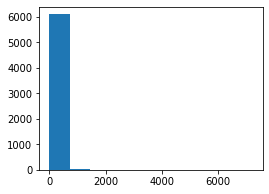

In [22]:
# 실제 거리의 오차를 히스토그램으로 시각화
plt.figure(figsize = (4, 3))
plt.hist(err_dists)
plt.show()

#### 2-5 노선별 실제 운행거리 시각화

In [ ]:
data = []
for route_id, values in driving_routes.items():
    data.append(values['path'])
draw_path(data, region=True)

<p>
<img src="post1/all_line.png" width="100%" align="center">
</p>

#### 2-6. 굴곡도 구하기

In [27]:
# 실제 노선의 길이와 최단거리 노선의 길이
driving_length = []
for route_id, its in driving_routes.items() :
    driving_length.append(its['path_length'])

shortest_length = []
for route_id, its in shortest_routes.items() :
    shortest_length.append(its['path_length'])

gulgok = pd.Series(driving_length)/pd.Series(shortest_length)
gulgok.head(3)

0    2.763846
1    1.093366
2    0.932136
dtype: float64

In [28]:
# 굴곡도 분포 확인
route_id = list(driving_routes.keys())
id_gul = pd.DataFrame([route_id, gulgok]).T
id_gul.rename(columns = {0 : 'route_id', 1 : '굴곡도'}, inplace = True)
id_gul.reset_index(inplace = True, drop =True)

# 굴곡도 데이터 저장
id_gul.to_csv('굴곡도.csv', index = False)

id_gul.head(3)

,route_id,굴곡도
0,228000204.0,2.763846
1,233000004.0,1.093366
2,233000005.0,0.932136


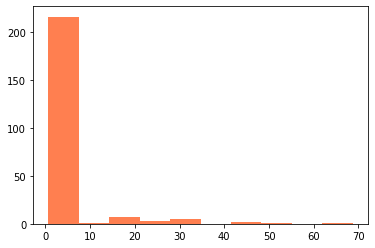

In [29]:
plt.hist(id_gul['굴곡도'], color = 'coral')
plt.show()

--> 굴곡도가 10 이상인 경우도 보인다. 좀 더 자세히 보자.

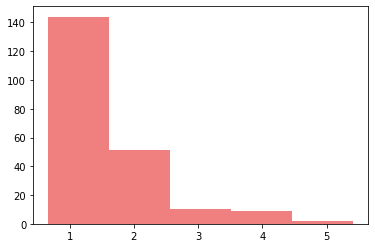

In [30]:
plt.hist(id_gul[id_gul['굴곡도']<10]['굴곡도'], color = 'lightcoral', bins = 5)
plt.show()

--> 굴곡도가 10미만일 때의 분포 그래프이다. 굴곡도가 1에 가까울 수록 시간/비용에 있어서 최적화되어있다고 한다.

### 2. 중복도    

* 중복도 = 비교 노선의 중복되는 정류장 수 / 기준노선의 정류장 수   
* 다른 노선들과 중복이 많이 되는 노선은 수정할 필요가 있다.  

<figure>
  <figcaption> [기준 노선(key_route)과 중복되는 노선(comparative_route), 중복도(%)] </figcaption>
  <img src="post1/중복도.png" alt="기준노선과 중복노선 중복도" style="width:30%">
</figure>


## 결과 도출  

* 엘보우 기법으로 최적의 K값을 찾은 뒤, 실루엣 기법으로 샘플의 수가 가장 적은 클러스터를 선택한다.  

### 엘보우 기법을 이용한 최적 K값 찾기  

<img src="post1/find_the_best_k.png" style="width:70%">



최적의 K값은 3이다.   
즉, 3개의 클러스터를 만들었을 때 클러스터 간의 거리와 클러스터 내의 샘플간의 거리가 비교적 적절하게 떨어져있다는 것을 의미한다.   


### 실루엣 기법으로 샘플의 수가 가장적은 클러스터 선택

<img src="post1/sil.png" style="width:70%">

그래프에는 2번 클러스터라고 적혀있지만 실제로 0, 1, 2 번으로 클러스터링되기 때문에 <span style="color:red">우리는 1번 클러스터를 선택</span>한다.  

### 지표 개발  

*  1번 클러스터 내의 샘플들 중에서 과연 우리는 몇 번 노선을 선택해야 하는지 모른다.   
   이를 위한 지표가 필요하다. 내가 개발한 지표는 다음과 같다.  

1. 각 컬럼별로 순위를 정한다.(예. 굴곡도가 가장 큰 노선의 순위는1, 가장 작은 노선의 순위는 14)  
2. 행별로 그 순위의 평균을 구한다.  
3. comparative_route(기존 노선과 비교했을 때 중복되는 노선)에서 중복되는 수를 분모로 취해서 가중치로 만든다.(예. 233000077은 세 번이 중복되므로 1/3) 중복되지 않는다면 1을 가중치로 한다.  
4. 2에서 구한 평균에 3에서 구한 가중치를 곱한다.  

* 아래에 간략하게 설명해놓았다.  
  <img src="post1/how_to_rank.png" style="width:70%">   

* 최종 결과  
  <img src="post1/final_count_rank.png" style = "width:50%">   

Final_rank가 작을 수록 수정이 시급한 노선이다.  
위의 결과에 따라 <span style="color:red">1000번, 81번, 22-3(신경대)번 노선</span>이 수정이 필요함을 결론내린다.  





